# This file implements Q-Learning for Dataset 2

Q-Learning and Double Q-Learning Algorithm Description

Q-Learning:

Q-learning is a reinforcement learning algorithm used to find the optimal action-selection policy for a given finite Markov decision process (MDP). The algorithm uses a Q-table to store the expected utility of actions taken in specific states. The agent updates the Q-values based on the rewards received and the expected future rewards (using the Bellman equation).

Double Q-Learning:

Double Q-learning addresses the overestimation bias in Q-learning by using two separate Q-tables (Q1 and Q2). Each Q-table is updated independently, using the other Q-table to estimate the value of the next state.

Implementation Steps 1.Preprocess the Data: Load and preprocess the bank dataset.

2.Implement Q-Learning: Set up and train a Q-learning model.

3.Implement Double Q-Learning: Set up and train a Double Q-learning model.

4.Evaluate the Models: Evaluate the performance of both models

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
px_template = "simple_white"

In [12]:
#Read dataset, check for null and duplicates
def read_dataset(dataset):
    
    data = pd.read_csv(dataset)
    nrow = len(data.index)
    ncol = len(data.columns)

    print("The dataset contains", format(nrow, ",d"), "rows and", ncol, "columns.")
    
    #Check for null values
    if ((data.isna().sum()).sum()) > 0:
        print("There are null items in the dataset")
    else:
        print("There are no null items in the dataset")
        
    #Check for duplicates
    
    #col_names = ["Country", "Year", "Status"]
    #(data.duplicated(subset=col_names)).sum()

    if (data.duplicated().sum()) > 0:
        print("There are duplicates in the dataset")
    else:
        print("There are no duplicates in the dataset")
        
    return data



#Function to categorize data into numeric and categorical
def categorize_data(data):
    
    numeric=[]
    categorical=[]
    numeric_dtypes = ["int64", "int32", "float64", "float32"]

    for i in range (len(data.columns)):
        if data[data.columns[i]].dtype in numeric_dtypes:
            numeric.append(data.columns[i])
        else:
            categorical.append(data.columns[i])
            
    return numeric, categorical

    
#Function to check for outliers
def outliers_check(data, numeric):
    outliers_sum =[]

    for col in (numeric):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        print(col, "", outliers.sum())
        outliers_sum.append(outliers.sum())

    return outliers.sum()


def remove_duplicates(data):
    duplicated_sum = data.duplicated().sum()
    if duplicated_sum == 0:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        return data
    else:
        print("Number of duplicated rows in dataset =", duplicated_sum)
        data = data[~data.duplicated()]
        print("Duplicated rows have been removed")
        return data

    
def remove_outliers(data, numeric):
    
    for col in (numeric):
        median_value = np.median(data[col])
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))
        #print(col, "", outliers.sum())
        data.loc[outliers, col] = median_value
    return data


# remove special characters from columns
def remove_spec_chars(data, categorical_cols):
    for col in categorical_cols:
        data[col] = data[col].str.replace(r'\W+', '').str.strip() #replaces special characters with white sapaces and removes the white spaces
    return data


def replace_unknown(data, categorical_cols):
    for col in categorical_cols:
        if "unknown" in data[col].values:
            #source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
            mode = data[col].mode()[0]
            data[col] = data[col].replace("unknown", mode)
    return data

    
def oneHotEncoding(data, categorical, drop_first):

    data_final = pd.get_dummies(data, columns=categorical, drop_first=drop_first)

    return data_final

In [13]:
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
file_name1 = "diabetes_binary_health_indicators_BRFSS2015.csv"
file_name2 = "diabetes_012_health_indicators_BRFSS2015.csv"
# Load the dataset
#df = pd.read_csv(file_name)
#df1 = pd.read_csv(file_name1)
#df2 = pd.read_csv(file_name2)

In [14]:
df1 = read_dataset("diabetes_binary_health_indicators_BRFSS2015.csv")

The dataset contains 253,680 rows and 22 columns.
There are no null items in the dataset
There are duplicates in the dataset


In [15]:
pd.set_option('display.max_columns', None)

df1.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [16]:
df1.shape

(253680, 22)

In [17]:
df1.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [18]:
#Checking information of dataframe df1

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [19]:
pd.set_option('display.max_columns', None)

df1.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [20]:
#checking unique val

unique_values = {}
for col in df1.columns:
    unique_values[col] = df1[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
Diabetes_binary,2
HighBP,2
HighChol,2
CholCheck,2
BMI,84
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2


In [21]:
#checking missing values of columns in Dataframe df1

df1.isnull().sum()


Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [22]:
df1 = remove_duplicates(df1)

Number of duplicated rows in dataset = 24206
Duplicated rows have been removed


In [23]:
#checking shape after eliminating duplicate rows

df1.shape

(229474, 22)

In [24]:
#Replacing 0 into Non-Diabetic and 1 into Diabetic
#adding new column Diabetes_binary_str

df1["Diabetes_binary_str"]= df1["Diabetes_binary"].replace({0:"NOn-Diabetic",1:"Diabetic"})

In [25]:
#average of column Daibetes_binary
# 0 for non-Diabetic person and 1 for Diabetic person

df1["Diabetes_binary_str"].value_counts()

NOn-Diabetic    194377
Diabetic         35097
Name: Diabetes_binary_str, dtype: int64

# Preprocessing

## Handling Outliers

In [26]:
numeric_cols, categorical_cols = categorize_data(df1)

In [27]:
# More insights into outliers
outliers = outliers_check(df1, numeric_cols)

Diabetes_binary  35097
HighBP  0
HighChol  0
CholCheck  9298
BMI  5638
Smoker  0
Stroke  10284
HeartDiseaseorAttack  23713
PhysActivity  0
Fruits  0
Veggies  47137
HvyAlcoholConsump  13950
AnyHealthcare  12389
NoDocbcCost  21323
GenHlth  12078
MentHlth  36162
PhysHlth  34346
DiffWalk  42625
Sex  0
Age  0
Education  0
Income  0


In [28]:
#remove outliers
removed_outliers=remove_outliers(df1, ['MentHlth', 'PhysHlth'])
(removed_outliers)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary_str
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,9.0,4.0,3.0,NOn-Diabetic
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,NOn-Diabetic
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,1.0,0.0,9.0,4.0,8.0,NOn-Diabetic
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,NOn-Diabetic
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,NOn-Diabetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0,NOn-Diabetic
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0,Diabetic
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,NOn-Diabetic
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0,NOn-Diabetic


In [29]:
#One hot encoding

data_encoded = oneHotEncoding(removed_outliers, categorical_cols, True)

data_encoded.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary_str_NOn-Diabetic
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,0.0,9.0,4.0,3.0,1
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,1
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,1.0,0.0,9.0,4.0,8.0,1
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,1
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,1


Accuracy of Q-learning policy: 50.92
Confusion Matrix for Q-learning:
[[ 3545  3537]
 [18989 19824]]
Classification Report for Q-learning:
              precision    recall  f1-score   support

           0       0.16      0.50      0.24      7082
           1       0.85      0.51      0.64     38813

    accuracy                           0.51     45895
   macro avg       0.50      0.51      0.44     45895
weighted avg       0.74      0.51      0.58     45895



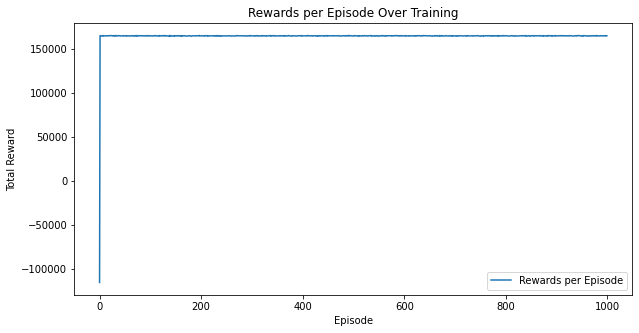

Accuracy of Double Q-learning policy: 50.76
Confusion Matrix for Double Q-learning:
[[ 3474  3608]
 [18990 19823]]
Classification Report for Double Q-learning:
              precision    recall  f1-score   support

           0       0.15      0.49      0.24      7082
           1       0.85      0.51      0.64     38813

    accuracy                           0.51     45895
   macro avg       0.50      0.50      0.44     45895
weighted avg       0.74      0.51      0.57     45895



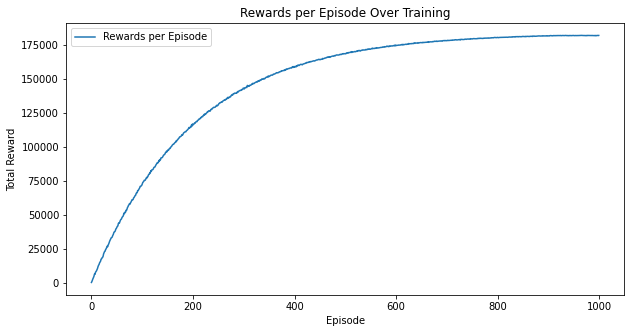

In [32]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Assuming binary_data is a DataFrame with the necessary data
# Example: binary_data = pd.read_csv('path_to_your_csv.csv')

# Define the states and actions
states = data_encoded.drop(columns=['Diabetes_binary_str_NOn-Diabetic']).values
actions = [0, 1]  # 0: no deposit, 1: deposit

# Split data into training and testing
train_states, test_states, train_target, test_target = train_test_split(states,data_encoded['Diabetes_binary_str_NOn-Diabetic'], test_size=0.2, random_state=42)

# Initialize Q-table
q_table = np.zeros((train_states.shape[0], len(actions)))

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration factor

# Initialize rewards_per_episode list
rewards_per_episode = []

# Training loop for Q-learning
for episode in range(1000):
    total_reward = 0
    for state_index, state in enumerate(train_states):
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table[state_index])

        # Reward is whether the action matches the actual deposit status
        reward = 1 if action == train_target.iloc[state_index] else -1
        total_reward += reward

        # Update Q-table
        old_value = q_table[state_index, action]
        next_max = np.max(q_table[state_index])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state_index, action] = new_value
    
    # Append total reward for this episode
    rewards_per_episode.append(total_reward)

# Test the learned Q-table
predictions = []
for state in test_states:
    state_index = np.where(np.all(train_states == state, axis=1))[0]
    if state_index.size > 0:
        action = np.argmax(q_table[state_index[0]])
    else:
        action = np.random.choice(actions)  # Random action if state not in training
    predictions.append(action)

# Calculate accuracy
accuracy_rl = round(accuracy_score(test_target, predictions) * 100, 2)
print("Accuracy of Q-learning policy:", accuracy_rl)

# Print confusion matrix and classification report for Q-learning
print("Confusion Matrix for Q-learning:")
print(confusion_matrix(test_target, predictions))
print("Classification Report for Q-learning:")
print(classification_report(test_target, predictions))

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode Over Training')
plt.legend()
plt.show()

# Scale the continuous features
scaler = StandardScaler()
train_states = scaler.fit_transform(train_states)
test_states = scaler.transform(test_states)

# Initialize Q-tables for Double Q-learning
q_table_1 = np.zeros((len(train_states), len(actions)))
q_table_2 = np.zeros((len(train_states), len(actions)))

# Hyperparameters
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
rewards_per_episode = []

# Training loop for Double Q-learning
for episode in range(num_episodes):
    total_reward = 0
    for state_index, state in enumerate(train_states):
        if np.random.rand() < epsilon:
            action = np.random.choice(actions)
        else:
            action = np.argmax(q_table_1[state_index] + q_table_2[state_index])

        next_state_index = np.random.randint(0, len(train_states))
        next_state = train_states[next_state_index]
        reward = 1 if action == train_target.iloc[state_index] else -1
        total_reward += reward

        if np.random.rand() < 0.5:
            best_next_action = np.argmax(q_table_1[next_state_index])
            q_table_1[state_index, action] = (1 - alpha) * q_table_1[state_index, action] + alpha * (reward + gamma * q_table_2[next_state_index, best_next_action])
        else:
            best_next_action = np.argmax(q_table_2[next_state_index])
            q_table_2[state_index, action] = (1 - alpha) * q_table_2[state_index, action] + alpha * (reward + gamma * q_table_1[next_state_index, best_next_action])
    
    rewards_per_episode.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Testing the learned policy
predictions = []
for state in test_states:
    state_index = np.where(np.all(train_states == state, axis=1))[0]
    if state_index.size > 0:
        action = np.argmax(q_table_1[state_index[0]] + q_table_2[state_index[0]])
    else:
        action = np.random.choice(actions)  # Random action if state not in training
    predictions.append(action)

accuracy_double_q = round(accuracy_score(test_target, predictions) * 100, 2)
print("Accuracy of Double Q-learning policy:", accuracy_double_q)

# Print confusion matrix and classification report for Double Q-learning
print("Confusion Matrix for Double Q-learning:")
print(confusion_matrix(test_target, predictions))
print("Classification Report for Double Q-learning:")
print(classification_report(test_target, predictions))

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label='Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode Over Training')
plt.legend()
plt.show()
